# Modello ANNNI - Evoluzione temporale e correlazioni
Luca Driussi, Carlo Tortora, Beatrice Volpato
<br>
Progetto di Computazione Quantistica
<br>
Anno 2024/25

## Introduzione

Il seguente progetto d'esame è dedicato allo studio del modello ANNNI (Axial-Next-Nearest-Neighbor-Ising). Questo modello, particolarmente interessante per l'analisi di transizioni di fase e fenomeni di frustrazione magnetica, è un'estensione del modello di Ising  che include interazioni tra spin secondi vicini. Studiamo il modello ANNNI per una catena unidimensionale di L spin, dunque consideriamo un'Hamiltoniana della forma:

$$
H_{ANNNI}=-J\sum_{i}(\sigma_z^i\sigma_z^{i+1}-\kappa\sigma_z^i\sigma_z^{i+2}+h\sigma_x^i).
$$

Il sistema è unidimensionale, dove $\sigma^i_\alpha$ sono le matrici di Pauli lungo la direzione i-esima dello spin $\sigma^i_\alpha\in \{x,y,z\} $ e assumiamo gli estremi della catena liberi. La scala di energia dell'Hamiltoniana è determinata dalla costante di accoppiamento 
$J$ (senza perdere generalità poniamo $J=1$), mentre i parametri adimensionali $\kappa$ e $h$ rappresentano rispettivamente l'interazione con il secondo vicino e con il campo magnetico trasverso. Ci limitiamo ai casi con $\kappa\geq 0$ e $h\geq 0$.
Facendo uso del framework Qiskit, l'obiettivo principale di questo lavoro è analizzare l'evoluzione temporale di alcune osservabili di interesse con due approcci:

- Evoluzione esatta: ottenuta diagonalizzando l'Hamiltoniana del sistema;

- Trotterizzazione all’ordine 2: permette di approssimare l'evoluzione temporale sfruttando la decomposizione di Suzuki-Trotter.

Oltre l'energia totale, le altre osservabili studiate sono la magnetizzazione per spin lungo $z$, lungo $x$ e la funzione di correlazione tra spin $i$-esimo e spin $j$-esimo:

$$
M_z=\frac{1}{L}\sum_i \sigma_z^i
$$
$$
M_x=\frac{1}{L}\sum_i \sigma_x^i
$$
$$
C(i,j)=\langle\sigma_x^i\sigma_x^{i+j}\rangle-\langle\sigma_x^i\rangle\langle\sigma_x^{i+j}\rangle.
$$

## Diagramma di fase

Il diagramma di fase a $T = 0K$ presenta tre fasi separate da due transizioni di fase del secondo ordine:

- Fase ferromagnetica: l'interazione tra primi vicini è quella dominante e tutti gli spin sono allineati nella direzione $z$, questo implica una magnetizzazione $M_z$ uniforme. 
- Fase paramagnetica: il campo magnetico trasverso domina, causando l'allineamento degli spin nella direzione $x$. Dunque la magnetizzazione lungo $x$ si rivela un parametro d'ordine rilevante per l'identificazione di transizioni di fase. 
- Fase antiferromagnetica: il reticolo è caratterizzato da una periodicità di quattro spin, composta da ripetizioni di due coppie di spin che puntano in direzioni opposte (una coppia concorde e l'altra discorde rispetto alla direzione del campo esterno... controllare).



## Implementazione del modello

In questa sezione descriviamo l'implementazione del modello ANNNI utilizzando il framework Qiskit.
Per prima cosa, viene costruita l'Hamiltoniana del sistema e vengono definite le osservabili di interesse. 

Dopo aver importato le librerie necessarie, vengono definiti i parametri del sistema fisico. In particolare, viene definito il numero di spin L, la forza dell'interazione tra primi vicini $J$, l'intensità del campo magnetico trasverso $h$ e il coefficiente di interazione tra secondi vicini $k$. Questi parametri determinano il comportamento della catena di spin e influenzano la sua evoluzione temporale. Successivamente viene costruita l'Hamiltoniana $H$ del sistema tramite la classe di Qiskit $\texttt{SparsePauliOp}$, che permette di definire operatori quantistici composti da prodotti di matrici di Pauli su diversi qubit, assegnando loro coefficienti reali o complessi. Allo stesso modo, vengono definiti gli operatori di magnetetizzazione $M_x$ e $M_z$.

In [20]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit.synthesis import SuzukiTrotter
import scipy.sparse as sp
import numpy as np
from qiskit.quantum_info import SparsePauliOp

# Hamiltoniana
def Get_hamiltonian(L, J, k, h, boundary='obc'):

    # Interazione a primi vicini
    ZZ1_list = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    if boundary == 'pbc':
        ZZ1_list.append(("ZZ", [L - 1, 0], -J))  # Termine in Z_L Z_1

    # Interazione a secondi vicini
    ZZ2_list = [("ZZ", [i, i + 2], k*J) for i in range(0, L - 2)]
    if boundary == 'pbc':
        ZZ2_list.append(("ZZ", [L - 2, 0], k*J))  # Termine in Z_L-1 Z_1
        ZZ2_list.append(("ZZ", [L - 1, 1], k*J))  # Termine in Z_L Z_2

    # Campo esterno
    X_list = [("X", [i], -h*J) for i in range(0, L)]

    # Conserva H come una matrice sparsa invece che come un array 2^L x 2^L
    H = SparsePauliOp.from_sparse_list([*ZZ1_list, *ZZ2_list, *X_list], num_qubits=L) 

    return H

# Valore di aspettazione dell'energia
def Energy_value(states, H):

    energy = [(np.real(sv.expectation_value(H))) for sv in states]

    return np.array(energy)

# Operatore magnetizzazione
def Magnetization_op(L, direction):

    magnetization_op = SparsePauliOp.from_sparse_list(
        [(direction, [i], 1.0) for i in range(0, L)], num_qubits=L)
    
    return magnetization_op

# Valore di aspettazione della magnetizzazione
def Magnetization_value(states, L, direction):
    
    magnetization_op = Magnetization_op(L, direction)

    magnetization = [(np.real(sv.expectation_value(magnetization_op))) for sv in states]

    return np.array(magnetization)


# Operatori per definire la correlazione a 2 spin
def Spin_1op(L, direction):

    spin_1op = [SparsePauliOp.from_sparse_list(
        [(direction, [i], 1.0)], num_qubits=L) for i in range(L)]
    
    return spin_1op

def Spin_2op(L, direction):

    spin_2op = [[SparsePauliOp.from_sparse_list(
        [(direction*2, [i, j], 1.0)], num_qubits=L) for i in range(L) if i != j] for j in range(L)]
    
    return spin_2op

# Valore di aspettazione della correlazione a 2 spin
def Correlation_value(states, L, direction):
    
    spin_1op = Spin_1op(L, direction)
    spin_2op = Spin_2op(L, direction)

    center = int(L/2)  # Si fissa un indice al centro della catena
    correlation = [None] * len(states)
    for i in range(len(states)):
        sv = states[i]
        correlation[i] = [(np.real(sv.expectation_value(spin_2op[center][j]))
                           -np.real(sv.expectation_value(spin_1op[center]))
                           *np.real(sv.expectation_value(spin_1op[j]))
                           ) for j in range(L-1)]
        correlation[i].insert(center, 1 - np.real(sv.expectation_value(spin_1op[center]))**2)
    
    return np.array(correlation)

## Evoluzione temporale

### Evoluzione esatta

Dato che il sistema è di piccole dimensioni (in termini di qubit) possiamo studiare l'evoluzione delle osservabili di interesse in maniera esatta:
- Diagonalizziamo $H_{ANNNI}$ trovandone gli autovalori $(E_i)$ e gli autostati $\vert \phi_i \rangle$;
- Evolviamo lo stato iniziale $\vert \psi(0) \rangle$ come $\vert \psi(t) \rangle = \sum_{i}c_{i}e^{-iE_{i}t}\vert \psi(0) \rangle$.

#### Implementazione

Viene definita una funzione chiamata $\texttt{Exact\_evolution}$ che prende in input $H$, lo stato iniziale $\texttt{initial\_state}$, l'intervallo di tempo $dt$ e il numero di steps temporali.

Lo stato corrente ($\texttt{current\_state}$) viene impostato come lo stato iniziale e viene creata la lista $\texttt{exact\_state}$ per memorizzare gli stati intermedi, iniziando con lo stato iniziale. Per ogni passo temporale, l'hamiltoniana $H$ viene convertita in una matrice sparsa. Successivamente, si calcola l'evoluzione temporale dello stato corrente utilizzando la funzione $\texttt{sp.linalg.expm\_multiply}$, che applica l'operatore di evoluzione temporale allo stato corrente per un intervallo di tempo $dt$. Il nuovo stato evoluto viene quindi aggiunto alla lista $\texttt{exact\_state}$. Questo processo viene ripetuto per il numero di passi specificato. Alla fine, la funzione restituisce la lista degli stati esatti calcolati per ogni intervallo di tempo.

In [21]:
def Exact_evolution(H, initial_state, dt, steps):
    
    current_state = initial_state  # Stato intermedio
    exact_state = [current_state]  # Lista su cui appendere ogni stato intermedio
    for _ in range(steps):
        
        # H come matrice sparsa
        H_sparse = H.to_matrix(sparse=True)

        # Evoluzione temporale lungo un passo dt
        current_state = Statevector(sp.linalg.expm_multiply(-1j * H_sparse, current_state.data, start=0, stop=dt, num=2)[-1])
        
        # Registrazione dello stato alla lista exact_state
        exact_state.append(current_state)
    
    return exact_state
    

In [22]:
from qiskit.quantum_info import Statevector
from qiskit_algorithms import TimeEvolutionProblem
from qiskit_algorithms import TrotterQRTE
from qiskit.primitives import Estimator
from qiskit.synthesis import SuzukiTrotter
import scipy.sparse as sp

# Stato iniziale come Statevector
def Get_initial_state(state_label, size, H=None, perturb_level=None):

    if isinstance(state_label, int):  # Trova l'autostato interessato e applica una perturbazione per discostarsi da esso

        if H is None or perturb_level is None:
            print('Error: must input both H and perturb_level to Get_initial_state')
            return None

        energies, eig_states = sp.linalg.eigsh(H.to_matrix(sparse=True), k=state_label + 1, which='SA')
        perturb = np.random.normal(0, perturb_level, size=size) + 1j * np.random.normal(0, perturb_level, size=size)
        psi = eig_states[:,0] + perturb
        psi /= np.linalg.norm(psi)  # Normalizzazione
        initial_state = Statevector(psi)  # Stato iniziale come Statevector

    elif state_label == 'random':  # Genera uno stato random
        psi = np.random.randn(size) + 1j * np.random.randn(size)  # Distribuzione uniforme
        psi /= np.linalg.norm(psi)  # Normalizzazione
        initial_state = Statevector(psi)  # Stato iniziale come Statevector

    else:  # La label sarà per es. 10010111
        initial_state = Statevector.from_label(state_label)
    
    return initial_state

# Si calcolano le osservabili per ogni t da una media su tot misure (shots)
def Shot_based_evolution(H, initial_state, trott_order, dt, steps, observables_op, shots): 

    # Condizioni iniziali e osservabili da calcolare all'interno di TimeEvolutionProblem
    problem = TimeEvolutionProblem(H,
                                   initial_state=initial_state,
                                   time=dt*steps,
                                   aux_operators=[*observables_op])

    # La formula da utilizzare va in TrotterQRTE
    if trott_order == 1:
        trotter = TrotterQRTE(num_timesteps=steps, 
                              estimator=Estimator(options={"shots": shots}))
    elif trott_order == 2:
        trotter = TrotterQRTE(product_formula=SuzukiTrotter(order=2), 
                              num_timesteps=steps, 
                              estimator=Estimator(options={"shots": shots}))

    # Evoluzione temporale
    result = trotter.evolve(problem)

    # Le osservabili si conservano in un array
    observables = np.array(np.array(result.observables)[:, :, 0])

    return observables  # array di shape (steps, n_osservabili)

# Si calcola lo stato trotterizzato per ogni t
def Statevector_evolution(H, initial_state, trott_order, dt, steps):
    
    # La formula da utilizzare va in TrotterQRTE
    if trott_order == 1:
        trotter = TrotterQRTE()
    elif trott_order == 2:
        trotter = TrotterQRTE(product_formula=SuzukiTrotter(order=2))

    current_state = initial_state  # Stato intermedio
    trott_state = [current_state] # Lista su cui appendere ogni stato intermedio
    for _ in range(steps):
        
        # Condizioni iniziali all'interno di TimeEvolutionProblem
        step_problem = TimeEvolutionProblem(H,
                                            initial_state=current_state,
                                            time=dt)

        # Evoluzione temporale lungo un passo dt
        result = trotter.evolve(step_problem)

        # Preparazione per il prossimo loop
        circuit = result.evolved_state
        current_state = Statevector.from_instruction(circuit)

        # Registrazione dello stato alla lista trott_state
        trott_state.append(current_state)
        
    return trott_state  # Lista di Statevectors
    #return [initial_state] * (steps + 1)

# Si calcola lo stato esatto per ogni t
def Exact_evolution(H, initial_state, dt, steps):
    
    current_state = initial_state  # Stato intermedio
    exact_state = [current_state]  # Lista su cui appendere ogni stato intermedio
    for _ in range(steps):
        
        # H come matrice sparsa
        H_sparse = H.to_matrix(sparse=True)

        # Evoluzione temporale lungo un passo dt
        current_state = Statevector(sp.linalg.expm_multiply(-1j * H_sparse, current_state.data, start=0, stop=dt, num=2)[-1])
        
        # Registrazione dello stato alla lista exact_state
        exact_state.append(current_state)
    
    return exact_state
    #return [initial_state] * (steps + 1)


### Trotterizzazione

L'evoluzione del sistema può essere simulata con il metodo della trotterizzazione. In breve, questa tecnica consiste nell'applicazione ripetuta di un certo gate quantistico; questa operazione approssima l'evoluzione temporale del sistema nell'intervallo di tempo discreto $dt$. A tal fine si utilizza un circuito ideale, ovvero privo di rumore. L'evoluzione trotterizzata è basata sul fatto di poter esprimere l'Hamiltoniana del sistema come una somma di termini $H_j$ costituiti da operatori di Pauli. La precisione della simulazione (rispetto all'evoluzione) esatta dipenderà dall'ordine di trotterizzazione scelto, se consideriamo i primi due ordini abbiamo le seguenti forumle: 

- Formula di Lie-Trotter al primo ordine:
$$
e^{-iHt} = U_1 + \mathcal{O}(tdt) = \left(\prod_{j=1}^M e^{-i a_j H_j dt} \right)^{steps} + \mathcal{O}(tdt) 
$$
- Formula di Suzuki-Trotter al secondo ordine:
$$
e^{-iHt} = U_2 + \mathcal{O}(tdt^2) = \left(\prod_{j=1}^M e^{-i a_j H_j dt/2} \prod_{j=M}^1 e^{-i a_j H_j dt/2} \right)^{steps} + \mathcal{O}(tdt^2) 
$$

dove il numero di steps di trotterizzazione è definito come $steps = t/dt$, in cui $dt$ è la lunghezza del singolo intervallo. Una volta identificato l'operatore che implementa la trotterizzazione, lo applichiamo allo stato iniziale $\vert \psi(0) \rangle$ del sistema e ricaviamo lo stato evoluto ad ogni step temporale. 
Per quanto riguarda l'evoluzione temporale delle osservabili, la tecnica adottata è quella di calcolare il valor medio rispetto allo stato evoluto ad ogni step di trotterizzazione. Quindi, per un generico osservabile:
$$
O(t_1) = \langle \psi(t_1) \vert O \vert \psi(t_1) \rangle
$$
$$
O(t_2) = \langle \psi(t_2) \vert O \vert \psi(t_2) \rangle
$$
$$
...
$$
$$
O(t) = \langle \psi(t) \vert O \vert \psi(t) \rangle
$$
Dove il tempo totale di evoluzione è $t = steps*dt$.


#### Implementazione #1

Viene definita una funzione $\texttt{Statevector\_evolution}$ che calcola l'evoluzione trotterizzata dello stato iniziale per un determinato numero di steps temporali. La funzione prende in input l'hamiltoniana $H$, lo stato iniziale $\texttt{initial\_state}$, l'ordine di Trotter $\texttt{trott\_order}$, l'intervallo di tempo $dt$ e il numero di steps temporali.

In base all'ordine, viene selezionata la formula di Trotter appropriata. Se l'ordine è 1, viene utilizzata la formula di Lie-Trotter di primo ordine, mentre se l'ordine è 2, viene utilizzata la formula di Suzuki-Trotter di secondo ordine. Lo stato corrente ($\texttt{current\_state}$) viene inizialmente impostato come lo stato iniziale e viene creata una lista $\texttt{trott\_state}$ per memorizzare gli stati intermedi, iniziando con lo stato iniziale.

Per ogni step temporale, vengono impostate le condizioni iniziali all'interno dell'oggetto $\texttt{TimeEvolutionProblem}$, che include l'Hamiltoniana
$H$, lo stato iniziale corrente e l'intervallo di tempo $dt$. Successivamente, viene calcolata l'evoluzione temporale dello stato corrente utilizzando il metodo $\texttt{evolve}$ dell'oggetto $\texttt{TrotterQRTE}$. Il risultato dell'evoluzione temporale è un circuito quantistico che rappresenta lo stato evoluto. Questo circuito viene poi convertito in un oggetto Statevector, che rappresenta lo stato quantistico evoluto.

Il nuovo stato evoluto viene aggiunto alla lista $\texttt{trott\_state}$, e il processo viene ripetuto per il numero di steps scelto. Alla fine, la funzione restituisce la lista degli stati trotterizzati calcolati per ogni step temporale.

In questa prima versione, l'intervallo $dt$ è fisso e si varia il tempo complessivo di simulazione.

In [ ]:
# Si calcola lo stato trotterizzato per ogni t
def Statevector_evolution(H, initial_state, trott_order, dt, steps):
    
    # La formula da utilizzare va in TrotterQRTE
    if trott_order == 1:
        trotter = TrotterQRTE()
    elif trott_order == 2:
        trotter = TrotterQRTE(product_formula=SuzukiTrotter(order=2))

    current_state = initial_state  # Stato intermedio
    trott_state = [current_state] # Lista su cui appendere ogni stato intermedio
    for _ in range(steps):
        
        # Condizioni iniziali all'interno di TimeEvolutionProblem
        step_problem = TimeEvolutionProblem(H,
                                            initial_state=current_state,
                                            time=dt)

        # Evoluzione temporale lungo un passo dt
        result = trotter.evolve(step_problem)

        # Preparazione per il prossimo loop
        circuit = result.evolved_state
        current_state = Statevector.from_instruction(circuit)

        # Registrazione dello stato alla lista trott_state
        trott_state.append(current_state)
        
    return trott_state  # Lista di Statevectors
    #return [initial_state] * (steps + 1)

#### Implementazione #2

Per osservare l'impatto del tempo complessivo di simulazione sull'accuratezza della trotterizzazione, è possibile implementare diversamente l'algoritmo di trotterizzazione. In questa seconda versione, per ogni istante $t$ la trotterizzazione viene eseguita a partire dallo stato iniziale con lo stesso numero di step. Questo implica che la trotterizzazione consideri intervalli $dt$ brevi a tempi ridotti e estesi a tempi lunghi.

In [ ]:
# Si calcola lo stato trotterizzato per ogni t
def Statevector_evolution_2(H, initial_state, trott_order, times, steps):
    
    # La formula da utilizzare va in TrotterQRTE
    if trott_order == 1:
        trotter = TrotterQRTE(num_timesteps=steps)
    elif trott_order == 2:
        trotter = TrotterQRTE(product_formula=SuzukiTrotter(order=2),num_timesteps=steps)

    trott_state = [initial_state]
    for t in times:

        # Salto dell'istante iniziale
        if t > 0:
            # Condizioni iniziali all'interno di TimeEvolutionProblem
            step_problem = TimeEvolutionProblem(H,
                                                initial_state=initial_state,
                                                time=t)
    
            # Evoluzione temporale fino a t
            result = trotter.evolve(step_problem)

            # Ottenimento dello stato
            circuit = result.evolved_state
            current_state = Statevector.from_instruction(circuit)

            # Registrazione dello stato alla lista trott_state
            trott_state.append(current_state)
        
    return trott_state  # Lista di Statevectors


#### Analisi degli errori

Una quantità interessante da studiare è l'errore introdotto dalla trotterizzazione, il quale è definito come
$$
||U(t)-e^{-iHt}||\leq \epsilon
$$
Dove $e^{-iHt}$ è l'operatore di evoluzione esatto e $U(t)$ è l'operatore che implementa l'evoluzione trotterizzata, a un generico ordine.
Per un'Hamiltoniana della forma $H=A+B$ l'errore introdotto è quantificato dalle seguenti formule $^{2}$:

- Al primo ordine di trotterizzazione:  $ ||U_1(t)-e^{-iHt}||\leq \frac{t^2}{2}||[B,A]|| $

- Al secondo ordine di trotterizzazione:  $ ||U_2(t)-e^{-iHt}||\leq \frac{t^3}{12}||[B,[B,A]]||+\frac{t^3}{24}||[A,[A,B]]||  $

Nel nostro caso, concentrandoci sul secondo ordine e prendendo 

$A=-J\sum_{i}(\sigma_z^i\sigma_z^{i+1}-\kappa\sigma_z^i\sigma_z^{i+2})$ 

$B=-J\sum_{i}h\sigma_x^i$

otteniamo che l'errore scala cubicamente nel tempo di evoluzione $t$ e quadraticamente nell'intensità del campo magnetico esterno $h$:
$$
||U_2(t)-e^{-iHt}|| \lesssim t^{3}h^{2}
$$

Inoltre, è possibile generalizzare la formula dell'errore dovuto alla trotterizzazione per un ordine arbitrario. Consideriamo $\rho(t)$ e $\rho_k(t)$, rispettivamente lo stato evoluto esattamente e la sua approssimazione ottenuta applicando la trotterizzazione di ordine $p$ con un numero $k$ di steps temporali. Per ogni $t \geq 0$ si ha $^{3}$:
$$
||\rho_k(t) -\rho(t)|| \lesssim \frac{t^{p+1}}{(p+1)!k^{p}}
$$

Ponendo l'ordine di trotterizzazione $p = 2$ e considerando $t=N_{steps}*dt=k*dt$ abbiamo l'andamento dell'errore in funzione di $dt$:

$$
||\rho_k(t) -\rho(t)|| \lesssim dt^2
$$

[1]: <a href="https://simons.berkeley.edu/sites/default/files/docs/15639/trottererrortheorysimons.pdf" target="_blank">simons.berkeley.edu</a>

[2]: <a href="https://doi.org/10.1103/PhysRevResearch.6.033309?_gl=1*11wa86y*_ga*ODIxODg5MjgxLjE3MzM1ODg0NDM.*_ga_ZS5V2B2DR1*MTc0MDMyNDM4MS44LjEuMTc0MDMyNDQ1Ny4wLjAuNTE0MTM1Ng.." target="_blank">PhysRevResearch</a>

In [60]:
# Parametri in H
L = 6  # Numero di siti
J = 1.  # Accoppiamento a primi vicini
boundary = 'obc'  # pbc o obc (open boundary conditions)

# Parametri dell'evoluzione
dt = 0.1  # Step di tempo
steps = 50  # Numero di step
final_time = dt*steps  # Tempo finale
trott_order = 2  # Ordine della trotterizzazione
method = 'statevector'  # statevector o shot-based
shots = 1024  # Solo shot-based
version = 1 # Tipo di evoluzione (secondo le implementazioni proposte), 1 o 2

# Stato iniziale in state_label:
# Metti per es.'1001101' per partire da uno stato a scelta in base Z,
# Metti 'random' per uno stato iniziale random,
# Metti un numero intero per partire dall'autostato corrispondente 
# (per spostarsi leggermente dall'autostato aumenta perturb_level)
state_label = 'random'
perturb_level = 0.01

Text(0.5, 0.98, 'Evoluzione delle osservabili in un circuito ideale - 50 step di trotterizzazione - statevector')

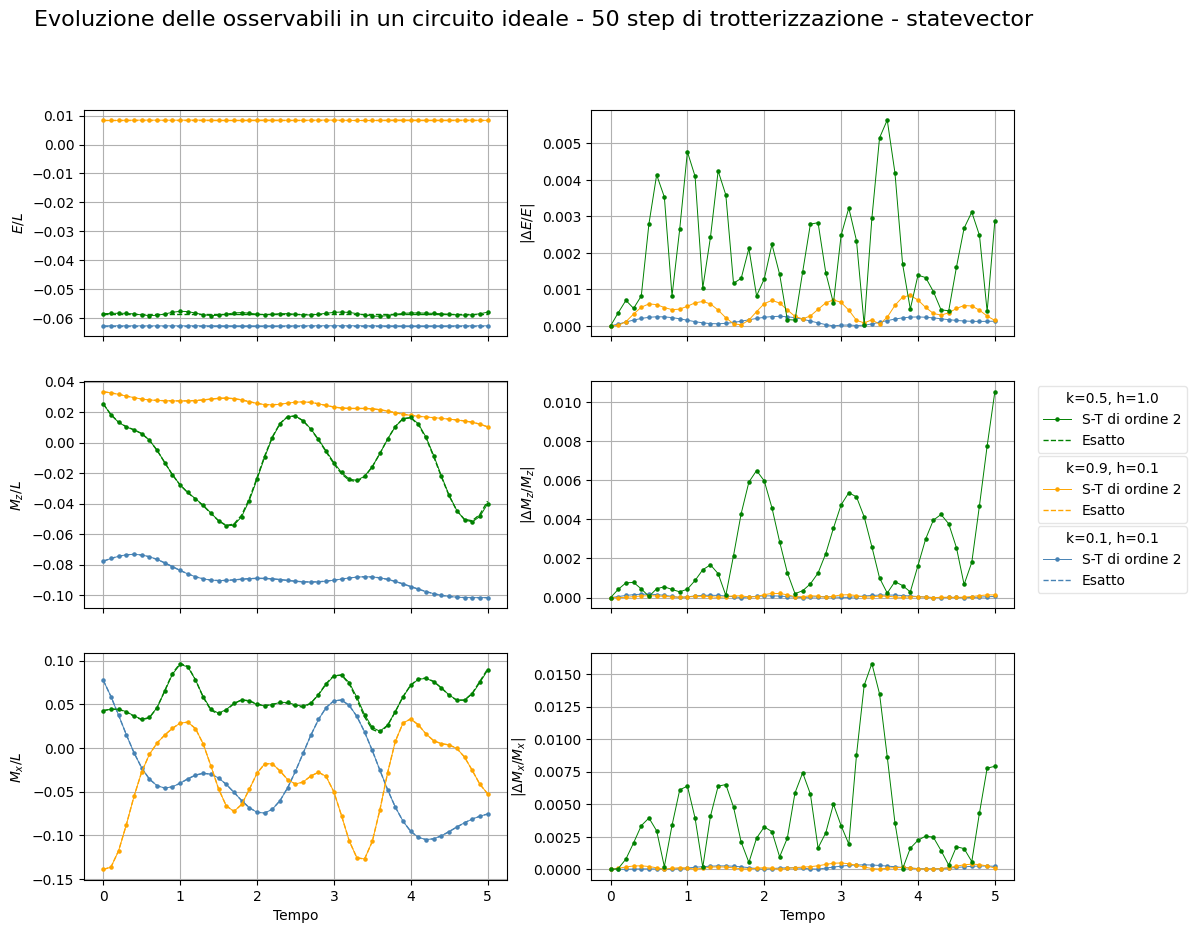

In [61]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Tempi su cui evolvere
times = np.linspace(0, final_time, steps + 1)  # Si include lo stato iniziale 

# Label degli assi
y_labels = [[r"$E/L$", r"$M_z/L$", r"$M_x/L$"],
            [r"$|\Delta E/E|$", r"$|\Delta M_z/M_z|$", r"$|\Delta M_x/M_x|$"]]
x_label = "Tempo"

fig, axes = plt.subplots(3, 2, sharex=True, figsize=(12, 10))

for i in range(3):
    for j in range(2):
        axes[i,j].grid()
        axes[i,j].set_ylabel(y_labels[j][i])
        if i == 2:
            axes[i,j].set_xlabel(x_label)

# Fasi su cui iterare
phase_list = [[0.1, 0.1],
              [0.9, 0.1],
              [0.5, 1.]]

# Un colore per ogni fase
color_list = ['steelblue', 'orange', 'green']
#color_list = [cm.Blues(i / (len(phase_list))) for i in range(1, len(phase_list) + 1)]

# Liste dove si salveranno i risultati
trott_results = [None] * len(phase_list)
exact_results = [None] * len(phase_list)

# Si itera su ogni fase
for p in range(len(phase_list)):

    # Parametri di ogni fase
    k, h = phase_list[p]
    color = color_list[p]
    
    # Valuta l'Hamiltoniana e lo stato iniziale
    H = Get_hamiltonian(L, J, k, h, boundary)
    initial_state = Get_initial_state(state_label, 2**L, H, perturb_level)

    # Si calcola psi ad ogni tempo
    if method == 'statevector':
        
        # Evoluzione
        if version == 1 :
            trott_state = Statevector_evolution(H, initial_state, trott_order, dt, steps)
        else if version == 2 :
            trott_state = def Statevector_evolution_2(H, initial_state, trott_order, times, steps)
        trott_results[p] = trott_state

        # Osservabili a partire dalla lista di stati trott_state
        energy = Energy_value(trott_state, H)
        magnetization_z = Magnetization_value(trott_state, L, 'Z')
        magnetization_x = Magnetization_value(trott_state, L, 'X')

    # Si misurano le osservabili ad ogni tempo
    elif method == 'shot-based':
    
        # Osservabili da valutare
        magnetization_z_op = Magnetization_op(L, 'Z')
        magnetization_x_op = Magnetization_op(L, 'X')
        observables_op = [H, magnetization_z_op, magnetization_x_op]

        # Evoluzione
        observables = Shot_based_evolution(H, initial_state, trott_order, dt, steps, observables_op, shots)
        trott_results[p] = observables

        # Osservabili a partire dalla lista di stati trott_state
        energy, magnetization_z, magnetization_x = observables.T
    
    # Evoluzione temporale esatta
    exact_state = Exact_evolution(H, initial_state, dt, steps)
    exact_results[p] = exact_state
    
    # Osservabili a partire dalla lista di stati trott_state
    exact_energy = Energy_value(exact_state, H)
    exact_magnetization_z = Magnetization_value(exact_state, L, 'Z')
    exact_magnetization_x = Magnetization_value(exact_state, L, 'X')

    # Plot di osservabili e deviazioni
    sim_data = [energy, magnetization_z, magnetization_x]
    exact_data = [exact_energy, exact_magnetization_z, exact_magnetization_x]
    for i, (sim_val, exact_val) in enumerate(zip(sim_data, exact_data)):
        
        # Plot di sinistra
        #axes[i,0].axhline(0, color="k", ls=":", lw=0.8)
        sim_plot, = axes[i,0].plot(times, sim_val/L, marker='.', markersize=4.5, ls='-', lw=0.7, label=f"S-T di ordine {trott_order}", color=color)
        exact_plot, = axes[i,0].plot(times, exact_val/L, ls="--", lw=1, label=f"Esatto", color=color)

        # Plot di destra
        #axes[i,1].axhline(0, color="k", ls=":", lw=0.8)
        axes[i,1].plot(times, abs((sim_val - exact_val)), marker=".", markersize=4.5, ls="-", lw=0.7, color=color)

    fig.legend(handles=[sim_plot, exact_plot], 
               loc="center right", 
               bbox_to_anchor=(1.05, 0.43 + 0.07*p),
               framealpha=0.5,
               title=f"k={k}, h={h:.1f}")

# Titolo generale
fig.suptitle(f"Evoluzione delle osservabili in un circuito ideale - {steps} step di trotterizzazione - statevector", fontsize=16)

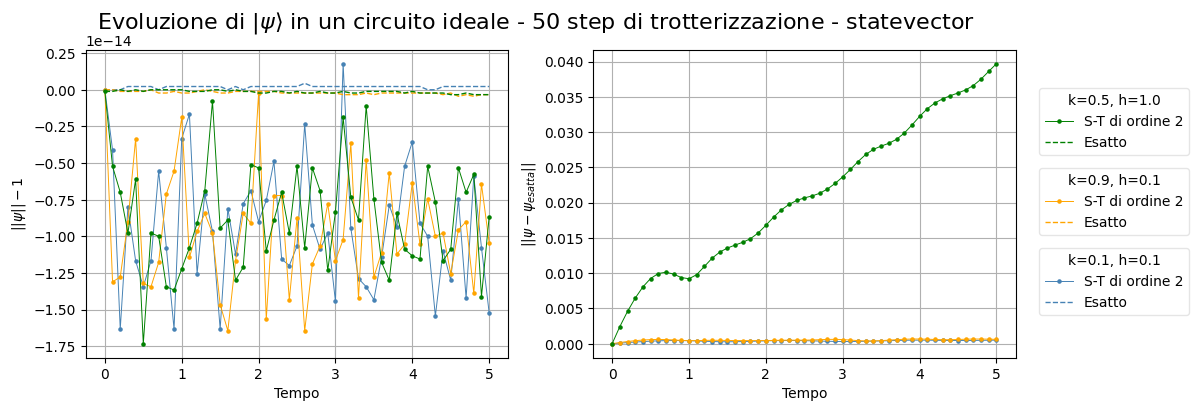

In [62]:
if method == 'statevector':
    
    # Labels assi
    y_labels = [r"$||\psi||-1$", r"$||\psi-\psi_{esatta}||$"]
    x_label = "Tempo"

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for j in range(2):
        axes[j].grid()
        axes[j].set_ylabel(y_labels[j])
        axes[j].set_xlabel(x_label)

    # Si itera su ogni fase
    for p in range(len(phase_list)):

        # Parametri di ogni fase
        k, h = phase_list[p]
        color = color_list[p]
        
        # Si usano i risultati appena ricavati
        trott_state = trott_results[p]
        exact_state = exact_results[p]

        # Modulo di psi simulato ed esatto
        mod_phi_exact = np.array([np.linalg.norm(sv.data) for sv in exact_state])
        mod_phi_trott = np.array([np.linalg.norm(sv.data) for sv in trott_state])

        # Norma della differenza tra psi simulato e psi esatto
        err_phi = [np.linalg.norm(trott_state[step]-exact_state[step]) for step in range(steps + 1)]  # Si include lo stato iniziale

        # Plot di sinistra
        #axes[0].axhline(0, color="k", ls=":", lw=0.8)
        sim_plot, = axes[0].plot(times, mod_phi_trott - 1, marker=".", markersize=4.5, ls="-", lw=0.7, label=f"S-T di ordine {trott_order}", color=color)
        exact_plot, = axes[0].plot(times, mod_phi_exact - 1, ls="--", lw=1, label=f"Esatto", color=color)

        # Plot di destra
        #axes[1].axhline(0, color="k", ls=":", lw=0.8)
        axes[1].plot(times, err_phi, marker=".", markersize=4.5, ls="-", lw=0.7, color=color)

        fig.legend(handles=[sim_plot, exact_plot], 
                loc="center right", 
                bbox_to_anchor=(1.05, 0.3 + 0.2*p),
                framealpha=0.5,
                title=f"k={k}, h={h:.1f}")

    # Titolo generale
    fig.suptitle(rf"Evoluzione di $|\psi\rangle$ in un circuito ideale - {steps} step di trotterizzazione - statevector", fontsize=16)

else:
    print('psi non viene calcolato con gli shot')

## Componenti dello stato rispetto alla base degli autostati di $H_{ANNNI}$

Studiare l'evoluzione delle coordinate dello stato nella base degli autostati di $H_{ANNNI}$ può essere utile per ottenere informazioni sulla dinamica del sistema. Il seguente codice costruisce un filmato che mostra il valore assunto da ciascuna componente in funzione del tempo.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Scelta dei parametri
k,h = [0.5,0.1]
initial_state = '000000'

# Creazione dello stato iniziale
psi = Statevector.from_label(initial_state)

# Definizione dell'Hamiltoniana
H = Get_hamiltonian(L, J, k, h, boundary='obc')

# Conversione in matrice
H_matrix = H.to_matrix()

# Ricerca di autovalori e autovettori
eigenvalues, eigenvectors = np.linalg.eigh(H_matrix)

# Costruzione degli autostati come Statevector
eigenstates = [Statevector(vec) for vec in eigenvectors.T]

# Espressione dello stato iniziale nella base degli autovettori di H
c = np.dot(eigenvectors.T.conj(), psi)

# Scelta dei tempi
t_values = np.linspace(0, final_time, steps)

# Evoluzione temporale esatta
def psi_t(t):
    phase_factors = np.exp(-1j * eigenvalues * t)
    return np.dot(eigenvectors, c * phase_factors)

# Setup per l'animazione
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()
bars = ax.bar(range(len(psi)), np.abs(psi_t(0))**2, color='g')
ax.set_ylim(0, 1)
ax.set_xticks(range(len(psi)))
ax.set_xticklabels(range(len(psi)),fontdict={'fontsize':4}) 
ax.set_xlabel("Componenti nella base di H")
ax.set_ylabel("Probabilità")

# Funzione di aggiornamento per l'animazione
def update(frame):
    psi = psi_t(t_values[frame])
    prob = np.abs(psi)**2
    for bar, p in zip(bars, prob):
        bar.set_height(p)
    return bars

# Creazione dell'animazione
ani = animation.FuncAnimation(fig, update, frames=len(t_values))
# ani.save(filename="video.gif",  fps=15, writer="pillow") # per salvare il filmato

matplotlib.animation.FuncAnimation(fig, update, frames=len(t_values), interval=15)

## Tempo caratteristico

Per studiare al meglio le osservabili che caratterizzano il modello ANNNI, è necessario determinare la scala di tempo caratteristica del sistema. Data l'Hamiltoniana $H_{ANNNI}$ e considerando $\hbar = 1$ abbiamo:
$$
\tau \sim \frac{1}{E}
$$
dove $E$ è la scala di energia caratteristica del sistema, data dalla differenza tra l'energia del primo stato eccitato e l'energia dello stato fondamentale.
A seconda del valore dei parametri $h$ (campo esterno) e $k$ (interazione tra secondi vicini), il modello presenta diverse scale di tempo:
- Campo esterno dominante ($h >> 1$): il termine di campo fa sì che gli spin osciliino rapidamente tra +1 e -1. La scala di tempo è corta, $ \tau \sim \frac{1}{h} $, quindi il sistema evolve velocemente.
- Interazione tra secondi vicini è dominante ($k >> 1$): l'interazione a lungo raggio stabilizza alcune configurazioni particolare degli spin, rallentando la dinamica. La scala dei tempi è data da $ \tau \sim \frac{1}{k} $.
- Interazioni tra primi vicini è dominante ($J = 1$ e $h, k << 1$): la dinamica è governata da interazioni locali, con una scala dei tempi dell'ordine di $ \tau \sim 1$.

Dunque abbiamo bisogno di identificare gli autovalori di $H_{ANNNI}$ relativi al ground state e al primo stato eccitato. A questo scopo viene definita una funzione chiamata $\texttt{get\_lowest\_states}$ che calcola autovalori e autostati corrispondenti ai due stati a energia minore di $H_{ANNNI}$, precedentemente rappresentata con la classe $\texttt{SparsePauliOp}$. In particolare, la funzione estrae gli autovalori e autostati corrispondenti allo stato fondamentale e al primo stato eccitato. Gli autostati sono rappresentati come oggetti $\texttt{Statevector}$.

In [25]:
import scipy.sparse.linalg as spla

# --- Calcoliamo gli autovalori del Ground State e del primo eccitato con la funzione get_lowest_states ---
def get_lowest_states(H: SparsePauliOp, num_states=2):

    # Converte H in una matrice sparsa
    H_matrix = H.to_matrix(sparse=True)

    # Trova autovalori e autostati di H
    eigenvalues, eigenvectors = spla.eigsh(H_matrix, k=num_states, which='SA')      #'SA' seleziona i più piccoli autovalori 

    # Normalizza e converte gli autostati in Statevector
    states = [Statevector(eigenvectors[:, i]) for i in range(num_states)]

    return eigenvalues, states

eigenvalues, states = get_lowest_states(H)                                          #Richiamo la funzione

ground_state = states[0]                                                            # Stato fondamentale
first_excited_state = states[1]                                                     # Primo stato eccitato

delta_energy = eigenvalues[1] - eigenvalues[0]
tau = 1/abs(delta_energy)

print("Ground state energy:", eigenvalues[0])
print("First excited state energy:", eigenvalues[1])
print("Delta energy", delta_energy)
print("Time scale", tau)

Ground state energy: -13.18201823412696
First excited state energy: -12.172840600557917
Delta energy 1.0091776335690437
Time scale 0.9909058293963708


## Studio delle correlazioni

In [24]:
import matplotlib.animation as animation
from IPython.display import HTML

# Parametri
L = 11
state_label = 0
perturb_level = 0.01
boundary = 'pbc'

# Fasi su cui iterare
phase_list = [[0.1, 0.1],
              [0.9, 0.1],
              [0.5, 1.]]

# Label degli assi
y_labels = [r"$\langle\sigma_z^{center}\sigma_z^i\rangle - \langle\sigma_z^{center}\rangle\langle\sigma_z^i\rangle$",
            r"$\langle\sigma_x^{center}\sigma^i_x\rangle - \langle\sigma_x^{center}\rangle\langle\sigma^i_x\rangle$"]
x_label = "Sito i"

fig, axes = plt.subplots(2, len(phase_list), sharex=True, sharey=True)

for i in range(2):
    axes[i,0].set_ylabel(y_labels[i])
    for j in range(len(phase_list)):
        axes[i,j].grid()
        axes[i,j].set_ylim(-1, 1)
        axes[i,j].set_yticks(np.linspace(-1, 1, 5))
        if i == 1:
            axes[1,j].set_xlabel(x_label)

# Un colore per ogni fase
color_list = ['steelblue', 'orange', 'green']
#color_list = [cm.Blues(i / (len(phase_list))) for i in range(1, len(phase_list) + 1)]

# Valori in ascissa
site = [i for i in range(L)]

exact_correlation_z = [None] * len(phase_list)
exact_correlation_x = [None] * len(phase_list)
bars = [[None] * len(phase_list) for _ in range(2)]
for p in range(len(phase_list)):

    # Parametri di ogni fase
    k, h = phase_list[p]
    color = color_list[p]

    # Valuta l'Hamiltoniana e lo stato iniziale
    H = Get_hamiltonian(L, J, k, h, boundary)
    initial_state = Get_initial_state(state_label, 2**L, H, perturb_level)
    
    # Evoluzione temporale esatta
    exact_state = Exact_evolution(H, initial_state, dt, steps)
    
    # Osservabili a partire dalla lista di stati trott_state
    exact_correlation_z[p] = Correlation_value(exact_state, L, 'Z')
    exact_correlation_x[p] = Correlation_value(exact_state, L, 'X')
    
    # Plot correlazioni esatte
    bars[0][p] = axes[0,p].bar(site, exact_correlation_z[p][0], color=color)
    bars[1][p] = axes[1,p].bar(site, exact_correlation_x[p][0], color=color)


def update(frame):
        
    for p in range(len(phase_list)):
        # Update the heights for Z correlation bars
        for bar, new_height in zip(bars[0][p], exact_correlation_z[p][frame]):
            bar.set_height(new_height)

        # Update the heights for X correlation bars
        for bar, new_height in zip(bars[1][p], exact_correlation_x[p][frame]):
            bar.set_height(new_height)
    
    return [bar for sublist in bars for bar in sublist]

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(times), interval=50, blit=False)
#HTML(ani.to_jshtml())
matplotlib.animation.FuncAnimation(fig, update, frames=len(times), interval=50)


/home/bvolpato/comp_quant/jupyter_env/lib/python3.12/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


## Fonti
[1] "Quantum phase detection generalization from marginal quantum neural network models", https://journals.aps.org/prb/abstract/10.1103/PhysRevB.107.L081105 <br>
[2] "A Theory of Trotter Error", https://arxiv.org/abs/1912.08854 <br>
[3] "Trotter error bounds and dynamic multi-product formulas for Hamiltonian simulation", https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.6.033309 <br>
